# Thermalization - Single Simulation

Text adapted from [1]: *In* [2, 3], *Dawson demonstrated that, independently of the initial velocity distribution
of the sheets, it is expected that over time the system will move towards thermal
equilibrium, and that this happens due to crossings/collisions involving more than 2
sheets* [2,3] *. The distribution function of
the sheet velocities is expected to converge to a normal distribution whose standard
deviation corresponds to the thermal velocity of the plasma.*

In this notebook we will show, for a single simulation, that a system initialized using a waterbag distribution in velocity space thermalizes to the expected normal distribution. Additionally, we will show the increase in the entropy of the system when correlations between particles are estabilished (i.e. after crossings) using a diagnostic similar to the one introduced in [4]. We will be using both the Sheet Model and the GNS.

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.1 <br>
[2] J. Dawson, Phys. Fluids 5.4 (1962) - See pp. 447-448 <br>
[3] J. Dawson, Phys. Fluids 7.3 (1964) <br>
[4] H. Liang et al., Phys. Plasmas 26 (2019) - See App. A

In [1]:
import os
import sys
import jax
import numpy as np

from pathlib import Path
from scipy import stats 
from scipy.optimize import curve_fit

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

sys.path.append('../..')
from sheet_model.synchronous import SyncSheetModel
from sheet_model.utils import get_relaxation_time, get_dx_eq, get_x_eq, get_E, get_fdist, get_Sxv
from gns.simulator import SMGNS
from gns.preprocess import init_GNS_as_SM

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Sheet Model 

### Simulation Parameters

In [2]:
# ----------------------------------
# Sheet model Simulation Options

opt = {
    'n_guards' : 10, # number of guards
    'n_sheets' : 1000, # number of sheets
    'dt' : 1e-1, # simulation dt [1/w_p]
    'boundary' : 'periodic', # boundary type (periodic or reflecting)
    'n_it_crossings' : 2, # number of iterations used to solve crossings
    'track_sheets': True,
    'L': 1
}

t_max = 500 # larger initial velocities require larger thermalization times
dt_undersample = 1 # choose so that dt * dt_undersample matches the GNS dt

dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])

### Initial Conditions

In [3]:
# for reproducibility
np.random.seed(42)

# initial positions of charge sheets [1/L]
x_0 = x_eq

# initial velocities
# the higher the initial value more time is needed to converge to gaussian
v_max = 2.5 * dx_eq 
v_0 = np.random.uniform(-v_max, v_max, opt['n_sheets'])

# aux variables
t_relax = get_relaxation_time(np.sqrt(1/3*(v_max/dx_eq)**2))

### Run Simulation

In [4]:
sim = SyncSheetModel(**opt)

X, V, X_eq, E = sim.run_simulation(x_0=x_0,
                                   v_0=v_0,
                                   t_max=t_max,
                                   dt_undersample=dt_undersample,
                                   verbose=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

## GNS

In [5]:
model_folder = Path(f'../../models/final/dt1e-1/4')
gns = SMGNS(model_folder, opt['boundary'])

assert gns.dt_train == opt['dt'] * dt_undersample, 'Sampling frequencies must coincide for plots to work!'

Simulator Info
   GNN model: ../../models/final/dt1e-1/4
   boundary: periodic
   L: 1
   dt_train: 0.1
   Training Dataset
      L: 1.0
      augment_t: True
      augment_x: True
      boundary: periodic
      data_folder: data/dataset/train/10/periodic/
      dt_simulator: 0.01
      dt_undersample: 10
      mode: crossings
      n_neighbors: 1
      n_sheets: 10
      save_folder: data/processed_temp/train/dt1e-1
      var_target: dvdt
      w_size: 1


### Run Simulation

In [6]:
x_0_gns, v_0_gns, _, _ = init_GNS_as_SM(x_0, v_0, x_eq, gns=gns)

X_gns, V_gns, X_eq_gns, E_gns = gns.pred_rollout(x_0_gns,
                                                 v_0_gns,
                                                 x_eq,
                                                 t_max=t_max,
                                                 verbose=True,
                                                 track_sheets=False,
                                                 n_guards=5 if gns.boundary=='reflecting' else 0,
                                                 np_=np)

  0%|          | 0/5000 [00:00<?, ?it/s]

## Check Energy Conservation

It is always a good proxy to check if the simulations are "meaningfull", i.e. if energy varies significantly, then crossings are badly resolved (dynamics are not modelled correctly).

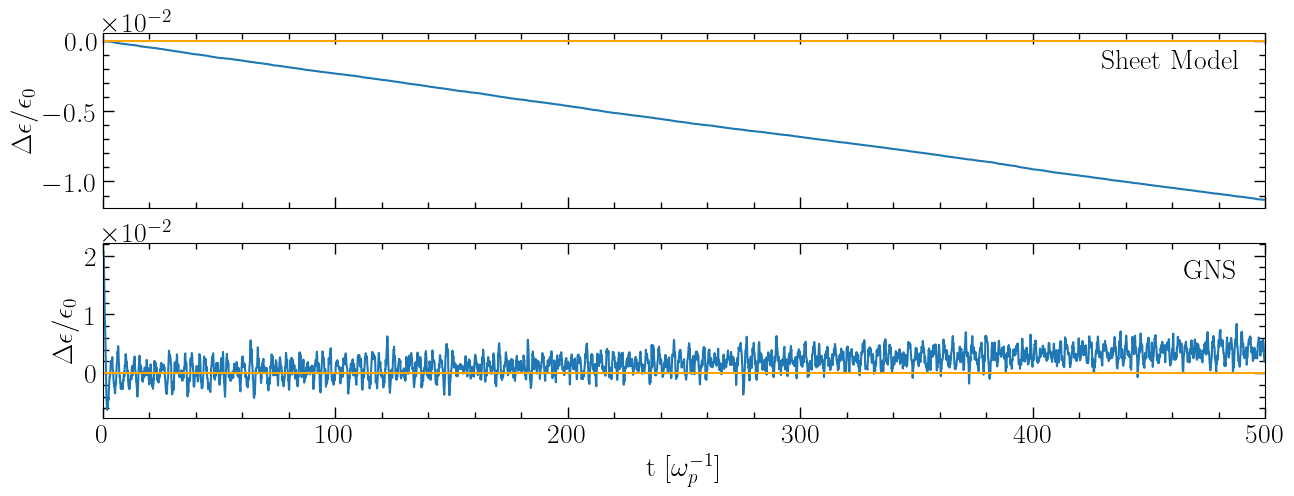

In [7]:
fig, ax = plt.subplots(2,1, figsize=(15,5), gridspec_kw={'hspace':0.2}) 

############# sheet model
T = np.arange(len(E)) * gns.dt_train

ax[0].plot(T, (E - E[0])/E[0])
ax[0].axhline(0, color='orange')
ax[0].annotate('Sheet Model', xy = (0,0), xytext = (0.86, 0.8), xycoords='axes fraction', 
               size=20, color = 'black', fontweight='bold')

############# gns
ax[1].plot(T, (E_gns - E[0])/E[0])
ax[1].axhline(0, color='orange')
ax[1].annotate('GNS', xy = (0,0), xytext = (0.93, 0.8), xycoords='axes fraction', 
               size=20, color = 'black', fontweight='bold')

for i, a in enumerate(ax):
    
    a.ticklabel_format(style='sci', axis='y',scilimits=(0,0)) 
    a.set_ylabel('$\Delta \epsilon / \epsilon_0$')
    a.set_xlim([T[0], T[-1]])
    
    if i == len(ax) - 1:
        a.set_xlabel('t [$\omega_p^{{-1}}$]')
    else:
        a.set_xticklabels([])        

plt.show()

## Evolution of $v$ distribution

### Single time-step

Sheet 	 mean: 0.04306 , std: 1.23251 [dx_eq w_p]
GNN 	 mean: 0.04443 , std: 1.25859 [dx_eq w_p]


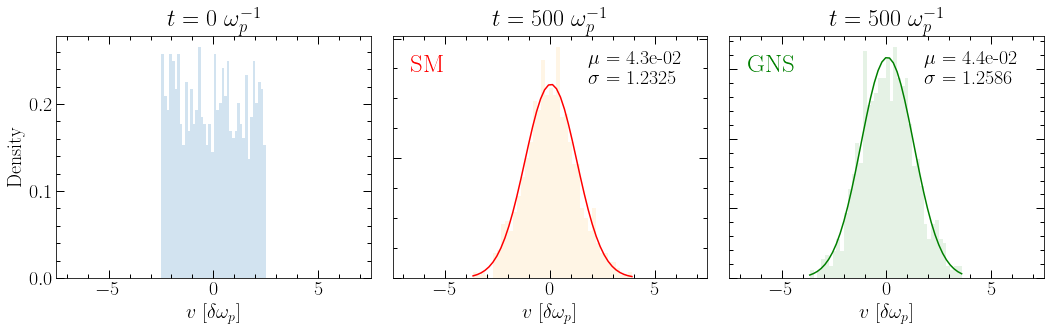

In [8]:
t = t_max # [1/wp]
it = int(t / gns.dt_train)

# convert V to units of dx_eq * w_p
V_norm = V / dx_eq
V_gns_norm = V_gns / dx_eq

assert it < len(V)

##########################################################################
# PLOT

fig, ax = plt.subplots(1,3,figsize=(15,5)) 
n_bins=40

############# t=0
ax[0].hist(V_norm[0].tolist(), alpha=0.2, bins=n_bins, density=True)

ax[0].set_title('$t = 0$ $\omega^{{-1}}_p$')

############# t=t_f [simulator]

nv, bins, _ = ax[1].hist(V_norm[it].tolist(), 
                       alpha=0.1, bins=n_bins, density=True, color='orange')

mu, sigma = stats.norm.fit(V_norm[it])

print(f'Sheet \t mean: {mu:.5f} , std: {sigma:.5f} [dx_eq w_p]')

best_fit_line = stats.norm.pdf(bins, mu, sigma)
ax[1].plot(bins, best_fit_line, color='red')

ax[1].annotate(f'$\mu$ = {mu:.1e}\n$\sigma$ = {sigma:.4f}', 
               xy = (0,0), xytext = (0.62, 0.80), xycoords='axes fraction', 
               size=20)

ax[1].annotate('SM', 
               xy = (0,0), xytext = (0.06, 0.85), xycoords='axes fraction', 
               size=25, color = 'red', fontweight='bold')

ax[1].set_title(f'$t = {t}$ $\omega^{{-1}}_p$')


############# t=t_f [gns]

nv_gns, bins_gns, _ = ax[2].hist(V_gns_norm[it].tolist(), 
                                 alpha=0.1, bins=n_bins, density=True, color='green')

mu, sigma = stats.norm.fit(V_gns_norm[it])
print(f'GNN \t mean: {mu:.5f} , std: {sigma:.5f} [dx_eq w_p]')

best_fit_line = stats.norm.pdf(bins_gns, mu, sigma)
ax[2].plot(bins_gns, best_fit_line, color='green')

ax[2].annotate(f'$\mu$ = {mu:.1e}\n$\sigma$ = {sigma:.4f}', 
               xy = (0,0), xytext = (0.62, 0.80), xycoords='axes fraction', 
               size=20)

ax[2].annotate('GNS', xy = (0,0), xytext = (0.06, 0.85), xycoords='axes fraction', 
               size=25, color = 'green', fontweight='bold')

ax[2].set_title(f'$t = {t}$ $\omega^{{-1}}_p$')

#############

for i, a in enumerate(ax):
    a.set_xlabel('$v$ [$\delta \omega_p$]')
    #a.set_ylim([0, 0.40])
    a.set_xlim([-3*v_max/dx_eq,3*v_max/dx_eq])
    a.locator_params(axis='y', nbins=4)
    
    if i > 0:
        a.set_yticklabels([])
    
    
ax[0].set_ylabel('Density')
plt.tight_layout()
plt.show()

### Time-average

Sheet 	 mean: -0.01138 , std: 1.24747 [dx_eq w_p]
GNN 	 mean: -0.00860 , std: 1.25584 [dx_eq w_p]


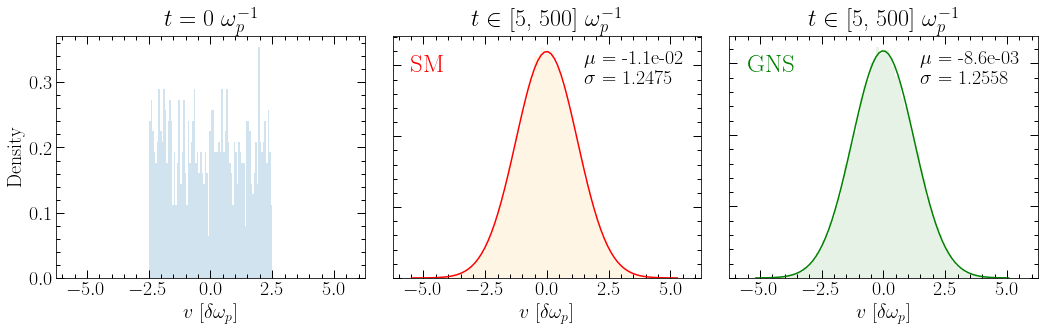

In [9]:
tmin = max(5, t_relax) # [1/wp]
tmax = t_max # [1/wp]
t = np.arange(tmin,tmax,2*np.pi) # [1/wp]
it = t / gns.dt_train
it = it.astype(np.int64)

# convert V to units of dx_eq * w_p
V_norm = V / dx_eq
V_gns_norm = V_gns / dx_eq

assert np.max(it) < len(V)

##########################################################################
# PLOT

fig, ax = plt.subplots(1,3,figsize=(15,5)) 
n_bins=80

############# t=0
ax[0].hist(V_norm[0].tolist(), alpha=0.2, bins=n_bins, density=True)

ax[0].set_title('$t = 0$ $\omega^{{-1}}_p$')

############# t=t_f [simulator]

nv, bins, _ = ax[1].hist(V_norm[it].flatten().tolist(), 
                         alpha=0.1, bins=n_bins, density=True, color='orange')

mu, sigma = stats.norm.fit(V_norm[it])

print(f'Sheet \t mean: {mu:.5f} , std: {sigma:.5f} [dx_eq w_p]')

best_fit_line = stats.norm.pdf(bins, mu, sigma)
ax[1].plot(bins, best_fit_line, color='red')

ax[1].annotate(f'$\mu$ = {mu:.1e}\n$\sigma$ = {sigma:.4f}', 
               xy = (0,0), xytext = (0.62, 0.80), xycoords='axes fraction', 
               size=20)

ax[1].annotate('SM', 
               xy = (0,0), xytext = (0.06, 0.85), xycoords='axes fraction', 
               size=25, color = 'red', fontweight='bold')

ax[1].set_title(f'$t \in$ [{tmin:.0f}, {tmax:.0f}] $\omega^{{-1}}_p$')

############# t=t_f [gns]

nv_gns, bins_gns, _ = ax[2].hist(V_gns_norm[it].flatten().tolist(), 
                                   alpha=0.1, bins=n_bins, density=True, color='green')

mu, sigma = stats.norm.fit(V_gns_norm[it])
print(f'GNN \t mean: {mu:.5f} , std: {sigma:.5f} [dx_eq w_p]')

best_fit_line = stats.norm.pdf(bins_gns, mu, sigma)
ax[2].plot(bins_gns, best_fit_line, color='green')

ax[2].annotate(f'$\mu$ = {mu:.1e}\n$\sigma$ = {sigma:.4f}', 
               xy = (0,0), xytext = (0.62, 0.80), xycoords='axes fraction', 
               size=20)

ax[2].annotate('GNS', xy = (0,0), xytext = (0.06, 0.85), xycoords='axes fraction', 
               size=25, color = 'green', fontweight='bold')

ax[2].set_title(f'$t \in$ [{tmin:.0f}, {tmax:.0f}] $\omega^{{-1}}_p$')

#############

for i, a in enumerate(ax):
    a.set_xlabel('$v$ [$\delta \omega_p$]')
    #a.set_ylim([0, 0.18])
    a.set_xlim([-2.5*v_max/dx_eq,2.5*v_max/dx_eq])
    a.locator_params(axis='y', nbins=4)
    
    if i > 0:
        a.set_yticklabels([])
    
    
ax[0].set_ylabel('Density')
plt.tight_layout()
#plt.savefig('../img/thermalization.pdf')
plt.show()

## Phase-space Evolution ($x-x_{eq}$, $v$)

#frames 145
...........Done!


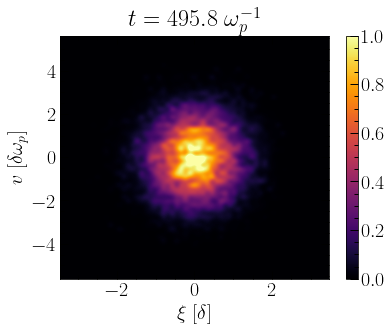

In [10]:
# fixed so that diagnostic is the same for SM and GNS
xrange = [-np.max(np.abs(X-X_eq))/dx_eq, np.max(np.abs(X-X_eq))/dx_eq]
vrange = [-np.max(np.abs(V))/dx_eq, np.max(np.abs(V))/dx_eq]


X_norm = X_gns/dx_eq
V_norm = V_gns/dx_eq
X_eq_norm = X_eq_gns/dx_eq

fps = 15
frames = []
titles = []

bins = 61 # chosen odd number to center 0

# first frames use small dt since distribution function changes fast
for i in np.arange(0,int(6/gns.dt_train), int(0.1/gns.dt_train)):
    aux = get_fdist(X_norm[i], X_eq_norm[i], V_norm[i], xrange, vrange, bins=bins)[0]
    frames.append(aux)
    titles.append(gns.dt_train*i)

# last frames use large dt + accumulate fdist (so that normal dist is visible)
for j, i in enumerate(np.arange(int(6/gns.dt_train), len(X), int(2*np.pi/gns.dt_train))):
    fdist = get_fdist(X_norm[i], X_eq_norm[i], V_norm[i], xrange, vrange, bins=bins)[0]
    fdist_cum = 1/(j + 1) * (fdist + frames[-1] * (j + 1))
    frames.append(fdist_cum)
    titles.append(gns.dt_train*i)

for j in range(5):
    frames.append(frames[-1])
    titles.append(gns.dt_train*i)
    
print('#frames', len(frames))
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6,5))

a = frames[0]
im = plt.imshow(a.T, interpolation='bicubic', aspect='auto', origin='lower',
                vmin=0, vmax=1, extent=[*xrange, *vrange], cmap='inferno')

ax = plt.gca()
ax.set_title(f"$t = {titles[0]:.1f} \ \omega_p^{{-1}}$")
plt.ylabel('$v$ $[\delta \omega_p]$')
plt.xlabel(r'$\xi$ $[\delta]$')
plt.tight_layout()
plt.colorbar()

def animate_func(i):
    if i % fps == 0:
        print('.', end='')
    im.set_array(frames[i].T)
    ax.set_title(f"$t = {titles[i]:.1f} \ \omega_p^{{-1}}$")
    return [im]

anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames = len(frames),
                               interval = 1000 / fps)

anim.save('../img/thermalization_phasespace.mp4', fps=fps)

print('Done!')

## Entropy Diagnostic

In [11]:
def get_S_evolution(x, x_eq, v, xrange, vrange, bins):
    S = {'total': [], 'x':[], 'v':[]}
    for i in range(len(v)):
        fdist, _, _ = get_fdist(x[i], x_eq[i], v[i], xrange, vrange, bins=bins, normalize=False)
        s = get_Sxv(fdist)
        for k,sk in s.items():
            S[k].append(sk)
    return S
    
# fixed so that diagnostic is the same for SM and GNS
bins = 101 # chosen odd number to center 0

In [12]:
t = np.arange(0,tmax, gns.dt_train)
S_sm = get_S_evolution(X[:len(t)]/dx_eq, X_eq[:len(t)]/dx_eq, V[:len(t)]/dx_eq, xrange, vrange, bins=bins)
S_gns = get_S_evolution(X_gns[:len(t)]/dx_eq, X_eq_gns[:len(t)]/dx_eq, V_gns[:len(t)]/dx_eq, xrange, vrange, bins=bins)

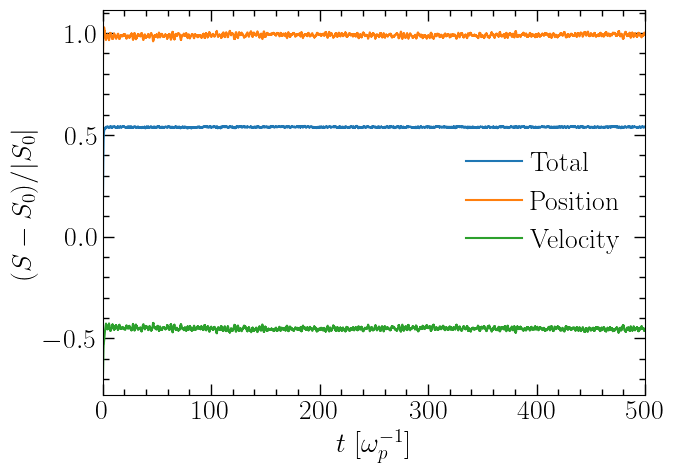

In [13]:
labels = {'x':'position', 'v':'velocity', 'total':'total'}

plt.figure()
for k in S_sm:
    plt.plot(t, (S_gns[k]-S_gns[k][0])/np.abs(S_gns['total'][0]), label=labels[k].capitalize())
    
plt.ylabel('$(S - S_0)/|S_0|$')
plt.xlabel('$t$ [$\omega_p^{-1}$]')
plt.xlim(0, tmax)
plt.legend()
plt.show()

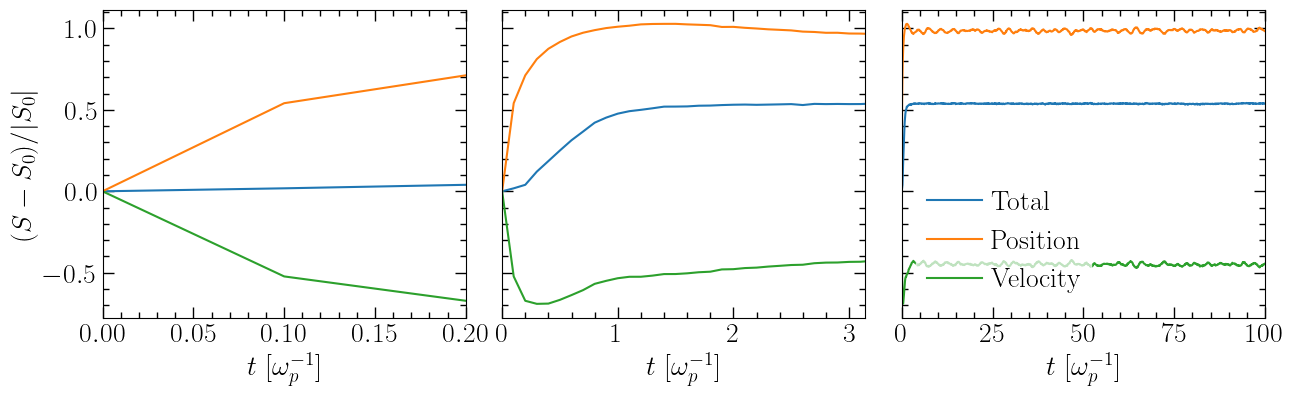

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,4), gridspec_kw={'wspace':0.1})

for ia, a in enumerate(ax):
    for k in S_sm:
        a.plot(t, (S_gns[k]-S_gns[k][0])/np.abs(S_gns['total'][0]), label=labels[k].capitalize())
    
    a.set_xlabel('$t$ [$\omega_p^{-1}$]')
    
    if ia != 0:
        a.get_yaxis().set_ticklabels([])

ax[0].set_ylabel('$(S - S_0)/|S_0|$')
ax[0].set_xlim(0, 1/2 / (v_max/dx_eq))
ax[1].set_xlim(0, np.pi)
ax[2].set_xlim(0, 100)
ax[2].legend()

#plt.tight_layout()
#plt.savefig('../img/thermalization_entropy')
plt.show()